In [1]:
# In this notebook, we try to implement some basic segmentation
# algorithms on "Retina Blood Vessel" dataset
#

In [2]:
# imports
#
import sys
import os
import glob
import time
import numpy as np
import scipy as sp
from scipy import ndimage, spatial
import skimage
from skimage import segmentation, io, filters, morphology
import sklearn
from sklearn import ensemble, metrics, svm, feature_extraction, model_selection
from sklearn import neural_network, preprocessing, decomposition
import matplotlib.pyplot as plt

from IPython.core.debugger import set_trace

In [3]:
# Globals
#
# br = breakpoint
br = set_trace
train_image_ipath = 'RetinaBloodVessels/train/image/'
train_mask_ipath = 'RetinaBloodVessels/train/mask/'
test_image_ipath = 'RetinaBloodVessels/test/image/'
test_mask_ipath = 'RetinaBloodVessels/test/mask/'
NROWS, NCOLS = 512, 512
EPSILON = 1e-6

In [4]:
# functions and classes

def read_images(path, rescale=True):
    images_fnames = sorted(glob.glob(os.path.join(path, '*.png')))
    images = []
    for fn in images_fnames:
        img = io.imread(fn)
        if rescale:
            img = np.uint32(img)/255
        images.append(img)
    images = np.array(images)
    return images

def gray(img):
    gr = img.mean(axis=2)
    gr = (gr - gr.min()) / (gr.max() - gr.min() + EPSILON)
    return gr

def show(img):
    if img.max != 255:
        img = np.float64(img)
        img = np.uint8(255*(img - img.min())/(img.max()-img.min() + EPSILON))
    fig = plt.figure(figsize=(5, 5))
    ax = fig.subplots()
    ax.imshow(img, cmap='gray')
    return True

def balance_dataset(fts, tgs):
    """
    This function only works for binary targets.
    It tries to randomly sample the features with 0 targets to make the 
    dataset balanced.
    """
    posfts = fts[tgs == 1, :]
    negfts = fts[tgs == 0, :]
    negfts = negfts[np.random.choice(range(negfts.shape[0]), 
                                     posfts.shape[0],
                                     replace=False), :]
    # concatenate and shuffle
    selfts = np.vstack((negfts, posfts))
    seltgs = np.hstack((np.zeros(negfts.shape[0]), np.ones(posfts.shape[0])))
    random_indices = np.arange(selfts.shape[0])
    np.random.shuffle(random_indices)
    selfts = selfts[random_indices, :]
    seltgs = seltgs[random_indices]
    return selfts, seltgs
    
def filters(image):
    """
    adds filtered dimensions to the main image.
    image should be 2D
    """
    filts = [[3, 1e-1], [3, 1e-2], [3, 1e-3],
             [5, 1e-2], [5, 1e-2], [5, 1e-3],
             [7, 1e-1], [7, 1e-2], [7, 1e-3]]
    images = np.zeros(image.shape + (len(filts) + 1, ))
    images[:, :, 0] = image
    for fc, filt in enumerate(filts):
        bw = image > skimage.filters.threshold_sauvola(
            image, window_size=filt[0], k=filt[1], r=None)
        images[:, :, fc+1] = bw * (image > 0.2)
    return images

def feat_targ(images, mask):
    """images: all filtered version of the original image with
               the shape of (nrows, ncols, nfilters)
    """
    ft = []
    nrows, ncols = tuple(images.shape[:2])
    iml = images.tolist()
    for rc in range(nrows):
        for cc in range(ncols):
            ft.append(iml[rc][cc] +  [mask[rc, cc]])
    return np.array(ft)

def patch_targ_2d(image, mask, neighbor=3):
    """
    Extracts patches with predefined neighbor size and returns it with the
    target.
    """
    pad = neighbor // 2
    padded_image = np.zeros((image.shape[0] + 2*pad, image.shape[1] + 2*pad))
    padded_image[pad:-pad, pad:-pad] = image
    patches = sklearn.feature_extraction.image.extract_patches_2d(
        padded_image, patch_size=[neighbor, neighbor])
    patches = patches.reshape((patches.shape[0], -1))
    targs = sklearn.feature_extraction.image.extract_patches_2d(
        mask, patch_size=[1, 1])
    targs = targs.reshape((targs.shape[0], -1))
    return patches, targs

def patch_targ_3d(image, mask, neighbor=3):
    """
    Extracts patches with predefined neighbor size and returns it with the
    target.
    """
    pad = neighbor // 2
    padded_image = np.zeros((image.shape[0] + 2*pad, 
                             image.shape[1] + 2*pad, 3))
    padded_image[pad:-pad, pad:-pad, :] = image
    patches = sklearn.feature_extraction.image.extract_patches_2d(
        padded_image, patch_size=[neighbor, neighbor])
    patches = patches.reshape((patches.shape[0], -1))
    targs = sklearn.feature_extraction.image.extract_patches_2d(
        mask, patch_size=[1, 1])
    targs = targs.reshape((targs.shape[0], -1))
    return patches, targs


In [5]:
# read all images and masks and store in two matrices
train_images = read_images(train_image_ipath, rescale=False)
train_masks = np.int64(read_images(train_mask_ipath, rescale=False) > 0)
test_images = read_images(test_image_ipath, rescale=False)
test_masks = np.int64(read_images(test_mask_ipath, rescale=False) > 0)
print(train_images.shape, train_masks.shape,
      test_images.shape, test_masks.shape)

(80, 512, 512, 3) (80, 512, 512) (20, 512, 512, 3) (20, 512, 512)


In [6]:
# # SLIC
# #
# image = train_images[0, :, :, :]
# gr = gray(image)
# mask = train_masks[0, :, :]
# seg = segmentation.slic(gr, n_segments=1000,
#                         compactness=10.0, max_num_iter=10,
#                         sigma=0, spacing=None, convert2lab=None,
#                         enforce_connectivity=True,
#                         min_size_factor=0.5, max_size_factor=3,
#                         slic_zero=False, start_label=1,
#                         mask=None, channel_axis=-1)

In [7]:
# # nilback
# #
# image = train_images[0, :, :, :]
# mask = train_masks[0, :, :]
# gr = gray(image)
# bw = skimage.filters.threshold_niblack(gr, window_size=11, k=0.99)
# show(1.0*(gr > bw))
# show(mask)

In [8]:
# # sauvola
# #
# image = train_images[0, :, :, :]
# mask = train_masks[0, :, :]
# gr = gray(image)
# trsh = skimage.filters.threshold_sauvola(
#     gr, window_size=7, k=15e-3, r=None)
# bw = (1 - (gr > trsh)) * (gr >= 0.2)

# pp = skimage.morphology.binary_closing(
#     bw, footprint=morphology.disk(1))

# # pp = skimage.morphology.binary_opening(
# #     bw, footprint=morphology.disk(1)) #footprint=np.ones((7, 7)))

# # pp = skimage.morphology.binary_erosion(
# #     bw, footprint=np.ones((2, 2))) #, footprint=morphology.disk(1))

# # med = filters.median(bw, footprint=morphology.disk(3))

# # show(gr)
# show(bw)
# show(pp)
# show(mask)

In [9]:
# imgs = filters(gr)

In [10]:
# ft = feat_targ(imgs, mask)

In [11]:
# ft.shape

In [12]:
# # classification
# rf = ensemble.RandomForestClassifier(
#     100, class_weight={0: 100, 1: 1}).fit(ft[:, :-1], ft[:, -1])
# tr_detect = rf.predict(ft[:, :-1])
# print(metrics.accuracy_score(mask.flatten(), tr_detect))
# show(tr_detect.reshape(NROWS, NCOLS))

In [13]:
# # classification
# sv = svm.SVC().fit(ft[:, :-1], np.uint64(ft[:, -1]))
# tr_detect = sv.predict(ft[:, :-1])
# print(metrics.accuracy_score(np.uint64(mask.flatten()), np.uint64(tr_detect)))
# show(tr_detect.reshape(NROWS, NCOLS))

In [14]:
# # Multi Otsu
# moth = skimage.filters.threshold_multiotsu(gr, classes=5, nbins=256)
# moth = np.hstack(([0], moth, [1]))
# print(moth)
# for thrc, trsh in enumerate(moth[1:]):
#     show(1.0*((moth[thrc] < gr) & (gr <= trsh)))
#     print(((moth[thrc] < gr) & (gr <= trsh)).sum())

In [15]:
# gf = skimage.filters.gabor_kernel(0.3, theta=0, bandwidth=1, n_stds=3)
# gf.shape

In [16]:
# fimg = ndimage.convolve(gr, gf, mode='constant')
# print(fimg.real.min(), fimg.real.max())
# print(fimg.imag.min(), fimg.imag.max())

In [17]:
# show(gr)
# show(fimg.real)
# show(fimg.imag)
# show(np.abs(fimg))

In [18]:
# mj = skimage.filters.meijering(gr, sigmas=range(1, 10, 2),
#                               alpha=None, black_ridges=True, mode='nearest')

In [57]:
# # Use patch-based ML model for binarization
# gray_images = train_images.mean(axis=3)
# gray_images = np.digitize(gray_images,
#                           bins=np.linspace(0, gray_images.max(), 256))
# # gray_images = gray_images / 256.0
# print(np.unique(gray_images).shape)
# # extract patch features
# neighb = 5
# pvecs, ptargs = np.zeros((0, neighb**2)), np.zeros((0, 1))
# for imgc in range(gray_images.shape[0]):
#     pvec, targ = patch_targ(gray_images[imgc, :, :],
#                             train_masks[imgc, :, :],
#                             neighbor=neighb)
#     pvecs = np.vstack((pvecs, pvec))
#     ptargs = np.vstack((ptargs, targ))
# # pvecs, targs = np.array(pvecs), np.array(targs)
# print(pvecs.shape, ptargs.shape)
# print(ptargs.sum())

(255,)


In [6]:
# extract patch features
neighb = 5
pvecs, ptargs = np.zeros((0, 3*neighb**2)), np.zeros((0, 1))
for imgc in range(train_images.shape[0]):
    pvec, targ = patch_targ_3d(train_images[imgc, :, :],
                               train_masks[imgc, :, :],
                               neighbor=neighb)
    pvecs = np.vstack((pvecs, pvec))
    ptargs = np.vstack((ptargs, targ))
# pvecs, targs = np.array(pvecs), np.array(targs)
pvecs = sklearn.preprocessing.MinMaxScaler(
    feature_range=(0.0, 1.0)).fit_transform(pvecs)
print(pvecs.shape, ptargs.shape)
print(ptargs.sum())

(20971520, 75) (20971520, 1)
2582676.0


In [7]:
# find unique (feature, target)
pvecs_ptargs = np.hstack((pvecs, ptargs))
feats_targs = np.unique(pvecs_ptargs, axis=0)
print(feats_targs.shape)
feats, targs = feats_targs[:, :-1], feats_targs[:, -1:]
nsamples, nfeats = feats.shape

(20792861, 76)


In [8]:
# search for equal features but different labels
uf, counts = np.unique(feats, return_counts=True, axis=0)
rep = uf[counts > 1, :]
print(rep.shape)
print(rep)
if len(rep) > 0:
    # print an example
    print(feats_targs[np.all(feats_targs[:, :-1] == rep[1, :], axis=1), :])

(0, 75)
[]


In [9]:
fts, tgs = feats_targs[:, :-1], feats_targs[:, -1]

In [ ]:
# # PCA
# pfts = sklearn.decomposition.PCA(n_components=25).fit_transform(fts)

In [31]:
# classification
t0 = time.time()
trft, tsft, trtg, tstg = sklearn.model_selection.train_test_split(ft, tg,
                                                        test_size=0.99)
rf = ensemble.RandomForestClassifier(100, 
                                     class_weight={0: 1, 1: 1}).fit(trft, trtg)
trpr = rf.predict(trft)
print(metrics.accuracy_score(trtg, trpr),
      metrics.balanced_accuracy_score(trtg, trpr))
tspr = rf.predict(tsft)
print(metrics.accuracy_score(tstg, tspr),
      metrics.balanced_accuracy_score(tstg, tspr))
print(f'Finished in {time.time() - t0:.0f} seconds.')
# show(tr_detect.reshape(NROWS, NCOLS))

0.9999566680629179 0.999824431352659
0.9263963396275287 0.7607602280430977


In [33]:
t0 = time.time()
trft, tsft, trtg, tstg = sklearn.model_selection.train_test_split(
    fts, tgs, test_size=0.30)
mlp = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=(40, 80, 40)).fit(trft, trtg)
trpr = mlp.predict(trft)
print(metrics.accuracy_score(trtg, trpr),
      metrics.balanced_accuracy_score(trtg, trpr))
tspr = mlp.predict(tsft)
print(metrics.accuracy_score(tstg, tspr),
      metrics.balanced_accuracy_score(tstg, tspr))
print(f'Finished in {time.time() - t0:.0f} seconds.')

0.9343879187156406 0.8020892382224575
0.9345106093827085 0.8022047883433414
Finished in 2095 seconds.


In [35]:
t0 = time.time()
trft, tsft, trtg, tstg = sklearn.model_selection.train_test_split(
    fts, tgs, test_size=0.30)
mlp = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=(40, ), activation='identity').fit(trft, trtg)
trpr = mlp.predict(trft)
print(metrics.accuracy_score(trtg, trpr),
      metrics.balanced_accuracy_score(trtg, trpr))
tspr = mlp.predict(tsft)
print(metrics.accuracy_score(tstg, tspr),
      metrics.balanced_accuracy_score(tstg, tspr))
print(f'Finished in {time.time() - t0:.0f} seconds.')

0.8746469491953496 0.5051415654515867
0.8744798983918136 0.5052545365114323
Finished in 212 seconds.


In [10]:
# make a balanced dataset
t0 = time.time()
trft, tsft, trtg, tstg = sklearn.model_selection.train_test_split(
    fts, tgs, test_size=0.30)
print(trft.shape, tsft.shape)
print(trtg.sum(), tstg.sum())
selft, seltg = balance_dataset(trft, trtg)
print(selft.shape, (seltg == 0).sum(), (seltg == 1).sum())
# mlp = sklearn.neural_network.MLPClassifier(
#     hidden_layer_sizes=(80, 40,), activation='relu',
#     solver='adam', batch_size=1000, 
#     max_iter=500).fit(selft, seltg)
# mlp = sklearn.neural_network.MLPClassifier(
#     hidden_layer_sizes=(20, 40, 20), activation='relu',
#     solver='adam', batch_size=1000, 
#     max_iter=500).fit(selft, seltg)
mlp = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=(80, 40,), activation='relu',
    solver='adam', batch_size=1000, 
    max_iter=500).fit(selft, seltg)

# evaluation on the different sets of samples
for label, ft, tg in [('selected features', selft, seltg),
                      ('train', trft, trtg),
                      ('test', tsft, tstg)]:
    print(label)
    pr = mlp.predict(ft)
    print(metrics.accuracy_score(tg, pr),
          metrics.balanced_accuracy_score(tg, pr),
          sklearn.metrics.jaccard_score(tg, pr),
          1-sp.spatial.distance.dice(tg, pr))
print(f'Finished in {time.time() - t0:.0f} seconds.')

(14555002, 75) (6237859, 75)
1806760.0 775916.0
(3613520, 75) 1806760 1806760
selected features
0.8868172861918573 0.8868172861918573 0.7988538760864177 0.888180954224478
train
0.8771507554585015 0.8865324783341922 0.47600334195783517 0.6449895178779793
test
0.8769653177476439 0.8862265474741344 0.4760117595973444 0.6449972454517574
Finished in 2084 seconds.


In [18]:
# No balanced dataset
t0 = time.time()
trft, tsft, trtg, tstg = sklearn.model_selection.train_test_split(
    fts, tgs, test_size=0.30)
print(trft.shape, tsft.shape)
print(trtg.sum(), tstg.sum())
mlp = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=(80, 40,), activation='relu',
    solver='adam', batch_size=1000, 
    max_iter=500).fit(trft, trtg)

# evaluation on the different sets of samples
for label, ft, tg in [('train', trft, trtg),
                      ('test', tsft, tstg)]:
    print(label)
    pr = mlp.predict(ft)
    print(metrics.accuracy_score(tg, pr),
          metrics.balanced_accuracy_score(tg, pr),
          sklearn.metrics.jaccard_score(tg, pr),
          1-sp.spatial.distance.dice(tg, pr))
print(f'Finished in {time.time() - t0:.0f} seconds.')

(14555002, 75) (6237859, 75)
1807898.0 774778.0
train
0.9453864726366922 0.8294958061938615 0.6056597670768321 0.7544061070664553
test
0.9452749733522351 0.8292578376233826 0.6050186228465707 0.7539085394206126
Finished in 3709 seconds.


In [140]:
pat0.shape[0] - 512*512

0

True

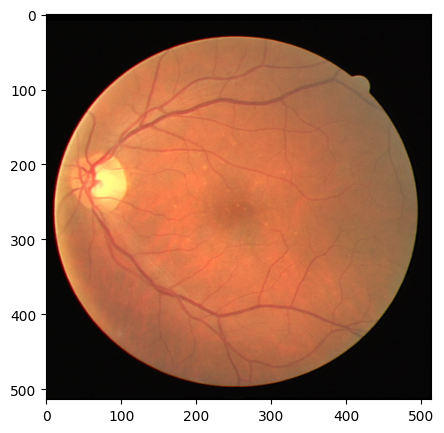

In [145]:
# reconstruct
ft0 = pvecs[:512*512]
pat0 = np.array([p.reshape((3, 3, 3)) for p in ft0])
img = sklearn.feature_extraction.image.reconstruct_from_patches_2d(
    pat0, image_size=(514, 514, 3))
show(img)

True

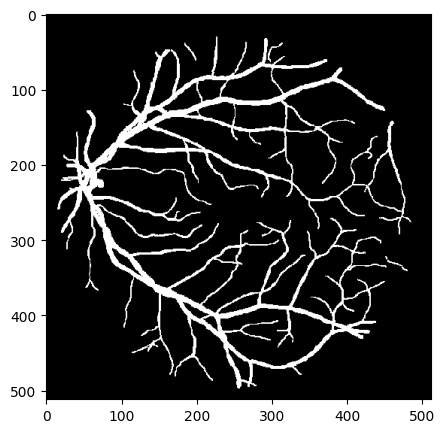

In [146]:
# mask reconstruction
mk0 = ptargs[:512*512]
mk0 = mk0.reshape((512, 512))
show(mk0)

True

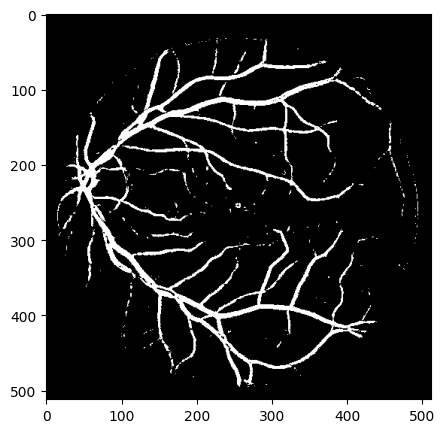

In [19]:
ft0 = pvecs[:512*512, :]
ft0 = sklearn.preprocessing.MinMaxScaler(
    feature_range=(0.0, 1.0)).fit_transform(ft0)
pmk0 = mlp.predict(ft0)
pmk0 = pmk0.reshape((512, 512))
show(pmk0)

In [67]:
jaccard = sklearn.metrics.jaccard_score(tg, pr)
dice = 2 * jaccard / (jaccard + 1)
print(jaccard, dice)

0.46654288729052723 0.6362485425195799


In [68]:
intersection = (tg * pr).sum()
dice = 2*intersection / (tg.sum() + pr.sum())
print(dice)

0.6362485425195799
